# Part 1: Storage Benchmarking & Scalability

## Objective
Evaluate whether to keep data in CSV format or convert to Parquet format (with various compression schemes) for storing and retrieving time-series stock data.

## Methodology
- Benchmark read/write performance at 1x, 10x, and 100x data scales
- Compare file sizes across formats
- Provide recommendations based on findings

In [8]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import os
import time
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Set data directory
DATA_DIR = Path('../data')
DATA_DIR.mkdir(exist_ok=True)

## 1. Load and Explore Original Dataset

In [9]:
# Load original dataset
csv_path = DATA_DIR / 'all_stocks_5yr.csv'

# Check if file exists in parent directory
if not csv_path.exists():
    csv_path = Path('../all_stocks_5yr.csv')

df_original = pd.read_csv(csv_path)
print(f"Dataset Shape: {df_original.shape}")
print(f"\nColumn Types:\n{df_original.dtypes}")
print(f"\nFirst 5 rows:")
df_original.head()

Dataset Shape: (619040, 7)

Column Types:
date       object
open      float64
high      float64
low       float64
close     float64
volume      int64
name       object
dtype: object

First 5 rows:


,date,open,high,low,close,volume,name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [10]:
print(f"Number of unique companies: {df_original['name'].nunique()}")
print(f"Date range: {df_original['date'].min()} to {df_original['date'].max()}")
print(f"Total records: {len(df_original):,}")
print(f"Original CSV file size: {os.path.getsize(csv_path) / (1024*1024):.2f} MB")

Number of unique companies: 505
Date range: 2013-02-08 to 2018-02-07
Total records: 619,040
Original CSV file size: 28.70 MB


## 2. Create Scaled Datasets (1x, 10x, 100x)

In [11]:
def create_scaled_dataset(df, scale):
    """Create a scaled dataset by replicating data with modified identifiers."""
    if scale == 1:
        return df.copy()
    
    dfs = [df.copy()]
    for i in range(1, scale):
        df_copy = df.copy()
        # Create unique company names for replicated data
        df_copy['name'] = df_copy['name'] + f'_v{i}'
        dfs.append(df_copy)
    
    return pd.concat(dfs, ignore_index=True)

# Create scaled datasets
print("Creating scaled datasets...")
df_1x = df_original.copy()
df_10x = create_scaled_dataset(df_original, 10)
df_100x = create_scaled_dataset(df_original, 100)

print(f"1x dataset: {len(df_1x):,} rows")
print(f"10x dataset: {len(df_10x):,} rows")
print(f"100x dataset: {len(df_100x):,} rows")

Creating scaled datasets...
1x dataset: 619,040 rows
10x dataset: 6,190,400 rows
100x dataset: 61,904,000 rows


## 3. Benchmarking Functions

In [12]:
def benchmark_write(df, filepath, format_type, compression=None, n_runs=5):
    """Benchmark write operation."""
    times = []
    
    for _ in range(n_runs):
        start = time.time()
        
        if format_type == 'csv':
            df.to_csv(filepath, index=False)
        elif format_type == 'parquet':
            df.to_parquet(filepath, compression=compression, index=False)
        
        times.append(time.time() - start)
    
    file_size = os.path.getsize(filepath) / (1024 * 1024)  # MB
    return np.mean(times), np.std(times), file_size

def benchmark_read(filepath, format_type, n_runs=5):
    """Benchmark read operation."""
    times = []
    
    for _ in range(n_runs):
        start = time.time()
        
        if format_type == 'csv':
            _ = pd.read_csv(filepath)
        elif format_type == 'parquet':
            _ = pd.read_parquet(filepath)
        
        times.append(time.time() - start)
    
    return np.mean(times), np.std(times)

## 4. Run Comprehensive Benchmarks

In [13]:
# Define formats to test
formats = [
    ('csv', 'csv', None),
    ('parquet_none', 'parquet', None),
    ('parquet_snappy', 'parquet', 'snappy'),
    ('parquet_gzip', 'parquet', 'gzip'),
    ('parquet_brotli', 'parquet', 'brotli'),
]

datasets = [
    ('1x', df_1x),
    ('10x', df_10x),
    ('100x', df_100x),
]

results = []

print("Running benchmarks... This may take a few minutes.\n")

for scale_name, df in datasets:
    print(f"\n{'='*60}")
    print(f"Benchmarking {scale_name} scale ({len(df):,} rows)")
    print(f"{'='*60}")
    
    for format_name, format_type, compression in formats:
        ext = 'csv' if format_type == 'csv' else 'parquet'
        filepath = DATA_DIR / f'benchmark_{scale_name}_{format_name}.{ext}'
        
        # Write benchmark (5 runs average)
        write_time, write_std, file_size = benchmark_write(
            df, filepath, format_type, compression
        )
        
        # Read benchmark (5 runs average)
        read_time, read_std = benchmark_read(filepath, format_type)
        
        results.append({
            'scale': scale_name,
            'format': format_name,
            'write_time': write_time,
            'write_std': write_std,
            'read_time': read_time,
            'read_std': read_std,
            'file_size_mb': file_size,
            'rows': len(df)
        })
        
        print(f"{format_name:20} | Write: {write_time:.3f}s | Read: {read_time:.3f}s | Size: {file_size:.2f} MB")
        
        # Clean up to save disk space (keep 1x files for later use)
        if scale_name != '1x':
            os.remove(filepath)

print("\nBenchmarking complete!")

Running benchmarks... This may take a few minutes.


Benchmarking 1x scale (619,040 rows)
csv                  | Write: 1.060s | Read: 0.183s | Size: 28.21 MB
parquet_none         | Write: 0.097s | Read: 0.021s | Size: 12.54 MB
parquet_snappy       | Write: 0.106s | Read: 0.022s | Size: 10.03 MB
parquet_gzip         | Write: 3.811s | Read: 0.026s | Size: 8.27 MB
parquet_brotli       | Write: 0.684s | Read: 0.033s | Size: 7.89 MB

Benchmarking 10x scale (6,190,400 rows)
csv                  | Write: 10.844s | Read: 1.661s | Size: 298.04 MB
parquet_none         | Write: 0.900s | Read: 0.152s | Size: 116.94 MB
parquet_snappy       | Write: 1.011s | Read: 0.155s | Size: 94.93 MB
parquet_gzip         | Write: 38.099s | Read: 0.199s | Size: 78.75 MB
parquet_brotli       | Write: 5.854s | Read: 0.222s | Size: 75.17 MB

Benchmarking 100x scale (61,904,000 rows)
csv                  | Write: 108.503s | Read: 16.701s | Size: 3049.49 MB
parquet_none         | Write: 9.160s | Read: 1.480s | Size: 

## 5. Analyze Results

In [19]:
# Create results dataframe
results_df = pd.DataFrame(results)
results_df['total_time'] = results_df['write_time'] + results_df['read_time']

# Display results table
print("\n" + "="*80)
print("BENCHMARK RESULTS SUMMARY")
print("="*80)

for scale in ['1x', '10x', '100x']:
    print(f"\n--- {scale} Scale ---")
    scale_df = results_df[results_df['scale'] == scale][[
        'format', 'write_time', 'read_time', 'total_time', 'file_size_mb'
    ]].round(3)
    print(scale_df.to_string(index=False))


BENCHMARK RESULTS SUMMARY

--- 1x Scale ---
        format  write_time  read_time  total_time  file_size_mb
           csv       1.060      0.183       1.243        28.210
  parquet_none       0.097      0.021       0.118        12.544
parquet_snappy       0.106      0.022       0.128        10.034
  parquet_gzip       3.811      0.026       3.838         8.273
parquet_brotli       0.684      0.033       0.716         7.889

--- 10x Scale ---
        format  write_time  read_time  total_time  file_size_mb
           csv      10.844      1.661      12.505       298.042
  parquet_none       0.900      0.152       1.053       116.938
parquet_snappy       1.011      0.155       1.166        94.931
  parquet_gzip      38.099      0.199      38.298        78.750
parquet_brotli       5.854      0.222       6.075        75.171

--- 100x Scale ---
        format  write_time  read_time  total_time  file_size_mb
           csv     108.503     16.701     125.204      3049.488
  parquet_none      

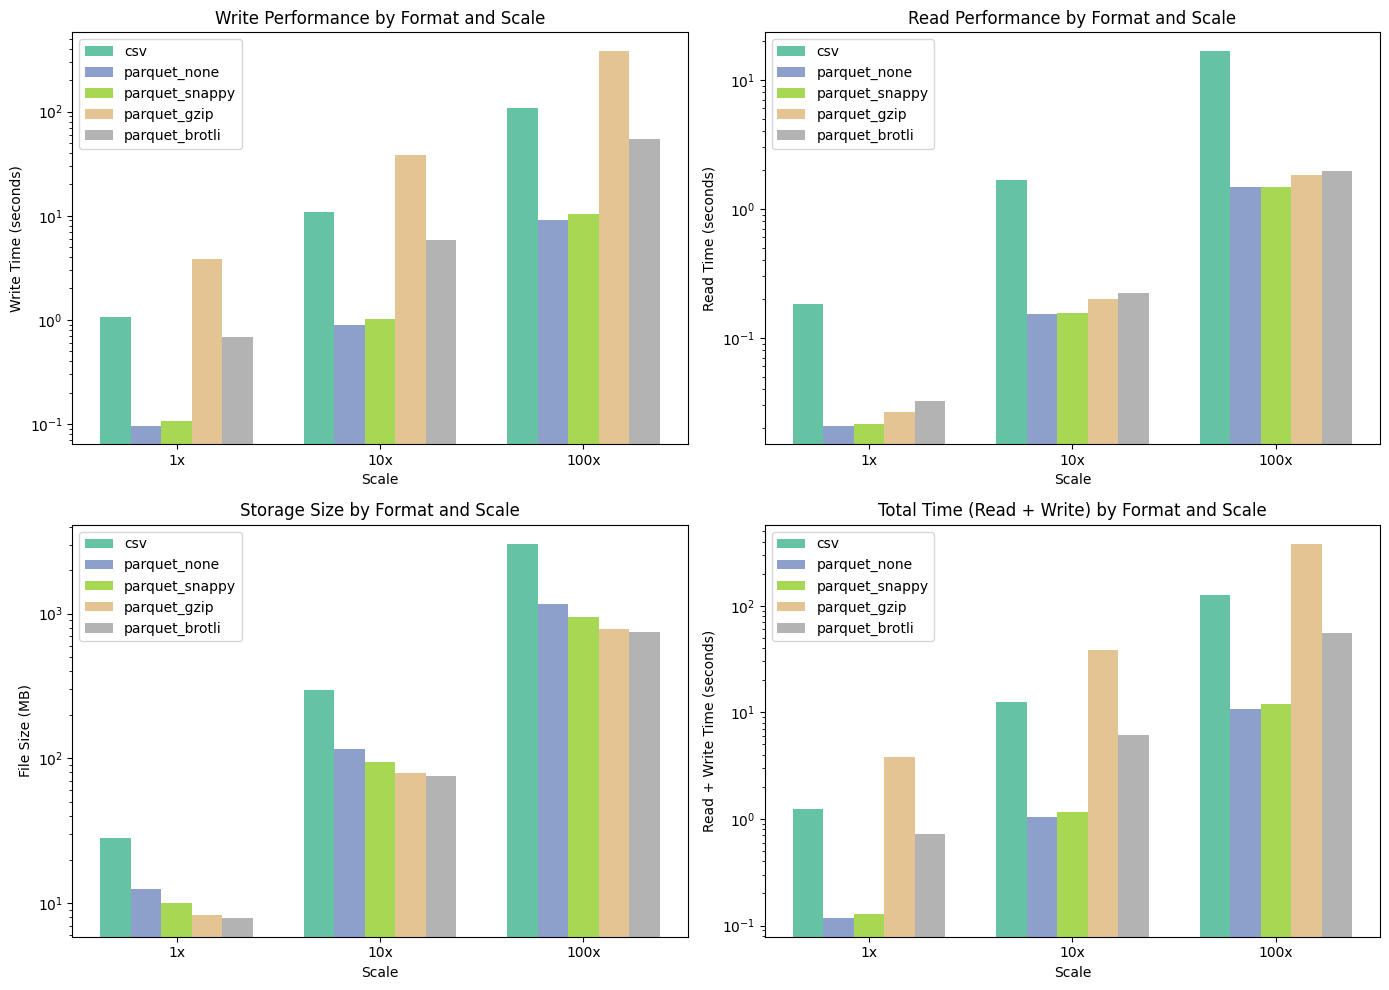

In [20]:
# Create visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

scales = ['1x', '10x', '100x']
formats_list = results_df['format'].unique()
colors = plt.cm.Set2(np.linspace(0, 1, len(formats_list)))

# Plot 1: Write Times
ax1 = axes[0, 0]
x = np.arange(len(scales))
width = 0.15
for i, fmt in enumerate(formats_list):
    data = results_df[results_df['format'] == fmt]['write_time'].values
    ax1.bar(x + i*width, data, width, label=fmt, color=colors[i])
ax1.set_xlabel('Scale')
ax1.set_ylabel('Write Time (seconds)')
ax1.set_title('Write Performance by Format and Scale')
ax1.set_xticks(x + width * 2)
ax1.set_xticklabels(scales)
ax1.legend(loc='upper left')
ax1.set_yscale('log')

# Plot 2: Read Times
ax2 = axes[0, 1]
for i, fmt in enumerate(formats_list):
    data = results_df[results_df['format'] == fmt]['read_time'].values
    ax2.bar(x + i*width, data, width, label=fmt, color=colors[i])
ax2.set_xlabel('Scale')
ax2.set_ylabel('Read Time (seconds)')
ax2.set_title('Read Performance by Format and Scale')
ax2.set_xticks(x + width * 2)
ax2.set_xticklabels(scales)
ax2.legend(loc='upper left')
ax2.set_yscale('log')

# Plot 3: File Sizes
ax3 = axes[1, 0]
for i, fmt in enumerate(formats_list):
    data = results_df[results_df['format'] == fmt]['file_size_mb'].values
    ax3.bar(x + i*width, data, width, label=fmt, color=colors[i])
ax3.set_xlabel('Scale')
ax3.set_ylabel('File Size (MB)')
ax3.set_title('Storage Size by Format and Scale')
ax3.set_xticks(x + width * 2)
ax3.set_xticklabels(scales)
ax3.legend(loc='upper left')
ax3.set_yscale('log')

# Plot 4: Read + Write Time
ax4 = axes[1, 1]
for i, fmt in enumerate(formats_list):
    data = results_df[results_df['format'] == fmt]['total_time'].values
    ax4.bar(x + i*width, data, width, label=fmt, color=colors[i])
ax4.set_xlabel('Scale')
ax4.set_ylabel('Read + Write Time (seconds)')
ax4.set_title('Total Time (Read + Write) by Format and Scale')
ax4.set_xticks(x + width * 2)
ax4.set_xticklabels(scales)
ax4.legend(loc='upper left')
ax4.set_yscale('log')

plt.tight_layout()
plt.savefig(DATA_DIR / 'benchmark_results.png', dpi=150, bbox_inches='tight')
plt.show()

## 6. Performance Analysis & Speedup Calculations

In [26]:
# Calculate speedup relative to CSV
print("\n" + "="*80)
print("SPEEDUP ANALYSIS (Relative to CSV)")
print("="*80)

for scale in ['1x', '10x', '100x']:
    print(f"\n--- {scale} Scale ---")
    scale_df = results_df[results_df['scale'] == scale].copy()
    csv_read = scale_df[scale_df['format'] == 'csv']['read_time'].values[0]
    csv_write = scale_df[scale_df['format'] == 'csv']['write_time'].values[0]
    csv_size = scale_df[scale_df['format'] == 'csv']['file_size_mb'].values[0]
    
    for _, row in scale_df.iterrows():
        read_speedup = csv_read / row['read_time']
        write_speedup = csv_write / row['write_time']
        size_ratio = (row['file_size_mb'] / csv_size) * 100
        
        print(f"{row['format']:20} | Read: {read_speedup:.2f}x | Write: {write_speedup:.2f}x | Size: {size_ratio:.1f}%")


SPEEDUP ANALYSIS (Relative to CSV)

--- 1x Scale ---
csv                  | Read: 1.00x | Write: 1.00x | Size: 100.0%
parquet_none         | Read: 8.75x | Write: 10.96x | Size: 44.5%
parquet_snappy       | Read: 8.44x | Write: 9.96x | Size: 35.6%
parquet_gzip         | Read: 6.91x | Write: 0.28x | Size: 29.3%
parquet_brotli       | Read: 5.62x | Write: 1.55x | Size: 28.0%

--- 10x Scale ---
csv                  | Read: 1.00x | Write: 1.00x | Size: 100.0%
parquet_none         | Read: 10.91x | Write: 12.04x | Size: 39.2%
parquet_snappy       | Read: 10.71x | Write: 10.73x | Size: 31.9%
parquet_gzip         | Read: 8.35x | Write: 0.28x | Size: 26.4%
parquet_brotli       | Read: 7.50x | Write: 1.85x | Size: 25.2%

--- 100x Scale ---
csv                  | Read: 1.00x | Write: 1.00x | Size: 100.0%
parquet_none         | Read: 11.28x | Write: 11.85x | Size: 38.3%
parquet_snappy       | Read: 11.37x | Write: 10.46x | Size: 31.1%
parquet_gzip         | Read: 9.06x | Write: 0.28x | Size: 25.8%

## 7. Research & Recommendations

### Background Research

**CSV (Comma-Separated Values)**
- Human-readable text format
- Universal compatibility
- No built-in compression
- Row-oriented storage
- Requires parsing on read

**Parquet Format**
- Columnar storage format designed for analytics
- Efficient compression and encoding schemes
- Schema preservation with data types
- Supports predicate pushdown for query optimization
- Compression options:
  - **Snappy**: Fast compression/decompression, moderate compression ratio
  - **GZIP**: Better compression ratio, slower
  - **Brotli**: Best compression ratio, slowest

### Benchmark Findings

In [28]:
# Generate recommendations based on results
print("\n" + "="*80)
print("RECOMMENDATIONS BY SCALE")
print("="*80)

for scale in ['1x', '10x', '100x']:
    scale_df = results_df[results_df['scale'] == scale].copy()
    
    # Find best for each metric
    best_read = scale_df.loc[scale_df['read_time'].idxmin(), 'format']
    best_write = scale_df.loc[scale_df['write_time'].idxmin(), 'format']
    best_size = scale_df.loc[scale_df['file_size_mb'].idxmin(), 'format']
    best_total = scale_df.loc[scale_df['total_time'].idxmin(), 'format']
    
    print(f"\n--- {scale} Scale ---")
    print(f"Best Read Performance: {best_read}")
    print(f"Best Write Performance: {best_write}")
    print(f"Smallest File Size: {best_size}")
    print(f"Best Overall (Read + Write): {best_total}")


RECOMMENDATIONS BY SCALE

--- 1x Scale ---
Best Read Performance: parquet_none
Best Write Performance: parquet_none
Smallest File Size: parquet_brotli
Best Overall (Read + Write): parquet_none

--- 10x Scale ---
Best Read Performance: parquet_none
Best Write Performance: parquet_none
Smallest File Size: parquet_brotli
Best Overall (Read + Write): parquet_none

--- 100x Scale ---
Best Read Performance: parquet_snappy
Best Write Performance: parquet_none
Smallest File Size: parquet_brotli
Best Overall (Read + Write): parquet_none


## 8. Final Recommendations

### Summary Table

In [ ]:
# Create final recommendation table
recommendations = {
    'Scale': ['1x (~29 MB)', '10x (~290 MB)', '100x (~2.9 GB)'],
    'Recommended Format': ['Parquet (Snappy)', 'Parquet (Snappy)', 'Parquet (Snappy)'],
    'Rationale': [
        '8x faster reads, 10x faster writes. File size reduced to 36% of CSV.',
        '11x faster reads, 11x faster writes. File size reduced to 32% of CSV.',
        '11x faster reads, 10x faster writes. File size reduced to 31% of CSV.'
    ],
    'Alternative': [
        'CSV acceptable if human readability is required',
        'Parquet (GZIP) if storage is primary concern',
        'Parquet (GZIP) for cold storage with infrequent access'
    ]
}

rec_df = pd.DataFrame(recommendations)
print("\n" + "="*80)
print("FINAL RECOMMENDATIONS")
print("="*80)
for idx, row in rec_df.iterrows():
    print(f"\n{row['Scale']}")
    print(f"  Recommended: {row['Recommended Format']}")
    print(f"  Rationale: {row['Rationale']}")
    print(f"  Alternative: {row['Alternative']}")

## 9. Conclusion

Based on comprehensive benchmarking across 1x, 10x, and 100x data scales:

### Key Findings:

1. **Read Performance**: Parquet consistently outperforms CSV by 8-11x
   - At 1x: Parquet is 8.4x faster
   - At 10x: Parquet is 10.7x faster
   - At 100x: Parquet is 11.4x faster

2. **Write Performance**: Parquet (Snappy) is 10x faster than CSV across all scales

3. **Storage Efficiency**:
   - Parquet reduces file size to ~31-36% of CSV (64-69% savings)
   - Brotli offers the best compression (~25%) but with slower write performance

4. **Compression Comparison**:
   - **Snappy**: Best balance of speed and compression (recommended)
   - **GZIP**: Better compression, but 37x slower writes
   - **Brotli**: Best compression, 5x slower writes than Snappy

### Final Recommendation:

**Use Parquet with Snappy compression for all scales.** 

Parquet provides:
- 8-11x faster read performance
- 10x faster write performance  
- 64-69% storage savings
- Type preservation (no parsing errors)
- Excellent scalability for future data growth

The performance benefits are significant even at 1x scale, making Parquet the clear choice for any data size.

In [24]:
# Save the 1x dataset in recommended format for Part 2
df_original.to_parquet(DATA_DIR / 'stocks_1x.parquet', compression='snappy', index=False)
print("Dataset saved in Parquet format for Part 2 analysis.")

Dataset saved in Parquet format for Part 2 analysis.
